***Nama : Laily Khoirunnisa'***

*Klasifikasi Teks Data 'Emotion Detection'*

`Submission 1 NLP Dicoding kelas Pengembangan Machine Learning`

<h1> <strong> 1. Mengambil dataset dari Kaggle</strong></h1>

In [153]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d praveengovi/emotions-dataset-for-nlp

Saving kaggle.json to kaggle.json
kaggle.json
  0% 0.00/721k [00:00<?, ?B/s]
100% 721k/721k [00:00<00:00, 49.2MB/s]


<h1> <strong> 2. Ekstrasi File Dataset </strong></h1>

In [154]:
!mkdir -p /tmp/emotions-dataset

In [155]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = 'emotions-dataset-for-nlp.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/emotions-dataset')
zip_ref.close()

<h1> <strong> 3. Preprosessing </strong></h1>

In [156]:
import pandas as pd
df = pd.read_csv('/tmp/emotions-dataset/train.txt', names=['sentence', 'label'], sep=';')
df.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [157]:
df.tail()

,sentence,label
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger
15999,i know a lot but i feel so stupid because i ca...,sadness


In [162]:
num_data = df['sentence'].size
max_len_sentence = max(df['sentence'].str.len())
num_words_sentence = sum(df['sentence'].str.len())
num_unique_words_sentence = df['sentence'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).size

In [163]:
print('Jumlah data : ',num_data)
print('Panjang maksimum kalimat : ',max_len_sentence)
print('Jumlah kata dalam semua data di kolom kalimat : ',num_words_sentence)
print('Jumlah kata unik dalam semua data di kolom kalimat : ',num_unique_words_sentence)

Jumlah data :  16000
Panjang maksimum kalimat :  300
Jumlah kata dalam semua data di kolom kalimat :  1549533
Jumlah kata unik dalam semua data di kolom kalimat :  15212


In [164]:
category = pd.get_dummies(df.label)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='label')
df_baru

,sentence,anger,fear,joy,love,sadness,surprise
0,i didnt feel humiliated,0,0,0,0,1,0
1,i can go from feeling so hopeless to so damned...,0,0,0,0,1,0
2,im grabbing a minute to post i feel greedy wrong,1,0,0,0,0,0
3,i am ever feeling nostalgic about the fireplac...,0,0,0,1,0,0
4,i am feeling grouchy,1,0,0,0,0,0
...,...,...,...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,0,0,0,1,0
15996,i am now turning and i feel pathetic that i am...,0,0,0,0,1,0
15997,i feel strong and good overall,0,0,1,0,0,0
15998,i feel like this was such a rude comment and i...,1,0,0,0,0,0


In [165]:
kalimat = df_baru['sentence'].values
label = df_baru[['anger', 'fear', 'joy', 'love', 'sadness','surprise']].values
print(kalimat)
print(label)

['i didnt feel humiliated'
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'
 'im grabbing a minute to post i feel greedy wrong' ...
 'i feel strong and good overall'
 'i feel like this was such a rude comment and im glad that t'
 'i know a lot but i feel so stupid because i can not portray it']
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 ...
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]]


In [166]:
from sklearn.model_selection import train_test_split
kalimat_latih, kalimat_test, label_latih, label_test = train_test_split(kalimat, label, test_size=0.2)

In [167]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=num_unique_words_sentence, oov_token='x')
tokenizer.fit_on_texts(kalimat_latih) 
tokenizer.fit_on_texts(kalimat_test)
 
sekuens_latih = tokenizer.texts_to_sequences(kalimat_latih)
sekuens_test = tokenizer.texts_to_sequences(kalimat_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

<h1><strong>4. Membuat Model</strong></h2>

In [168]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=num_unique_words_sentence, output_dim=64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 64)          973568    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_59 (Dense)             (None, 6)               

<h1><strong>5. Deklarasi Callbacks</strong></h2>

In [169]:
#EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 15)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

<h1><strong>6. Proses Training dan Pengujian</strong></h2>

In [170]:
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), 
                    verbose=1,
                    callbacks=[es, mc]
                    )

Epoch 1/30
400/400 [==============================] - 19s 45ms/step - loss: 1.2825 - accuracy: 0.4880 - val_loss: 0.7528 - val_accuracy: 0.7147

Epoch 00001: val_accuracy improved from -inf to 0.71469, saving model to ./model.h5
Epoch 2/30
400/400 [==============================] - 17s 44ms/step - loss: 0.4786 - accuracy: 0.8322 - val_loss: 0.4180 - val_accuracy: 0.8672

Epoch 00002: val_accuracy improved from 0.71469 to 0.86719, saving model to ./model.h5
Epoch 3/30
400/400 [==============================] - 17s 43ms/step - loss: 0.2035 - accuracy: 0.9346 - val_loss: 0.3137 - val_accuracy: 0.8941

Epoch 00003: val_accuracy improved from 0.86719 to 0.89406, saving model to ./model.h5
Epoch 4/30
400/400 [==============================] - 17s 43ms/step - loss: 0.1158 - accuracy: 0.9620 - val_loss: 0.3849 - val_accuracy: 0.8966

Epoch 00004: val_accuracy improved from 0.89406 to 0.89656, saving model to ./model.h5
Epoch 5/30
400/400 [==============================] - 17s 44ms/step - loss:

<h1><strong>7. Membuat Plot Tingkat Akurasi Data Training dan Validasi</strong></h2>

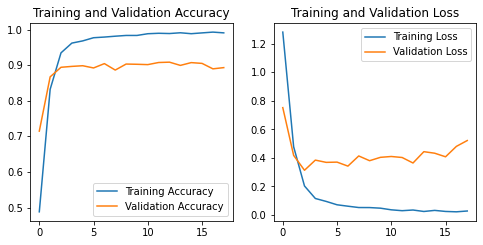

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1><strong>8. Prediksi Emosi Di Luar Dataset</strong></h2>

In [172]:
import re
import nltk 
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def text_preprocess(text, stop_words=False):
  '''
  Accepts text (a single string) and
  a parameters of preprocessing
  Returns preprocessed text

  '''
  # clean text from non-words
  text = re.sub(r'\W+', ' ', text).lower()

  # tokenize the text
  tokens = word_tokenize(text)

  if stop_words:
    # delete stop_words
    tokens = [token for token in tokens if token not in STOPWORDS]

  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [173]:
import numpy as np

def predict(texts):
  '''
  Accepts array if texts (strings)
  Prints sentence and the corresponding label (emotion)
  Returns nothing
  
  '''
  emotions = ['anger', 'fear', 'joy', 'love', 'sadness','surprise']

  texts_prepr = [text_preprocess(t) for t in texts]
  sequences = tokenizer.texts_to_sequences(texts_prepr)
  pad = pad_sequences(sequences)

  predictions = model.predict(pad)
  labels = np.argmax(predictions, axis=1)
  
  for i, lbl in enumerate(labels):
    print(texts[i],' --> ', emotions[lbl])

In [175]:
test_texts = ['I am so happy', 
              'The man felt lonely', 
              'The guests felt satisfied', 
              'He was really disappointed',
              'She surprised',
              'Not a day goes on without thinking of him',
              'She angry with him',
              'He feels intense fear when he has to fly']

predict(test_texts)

I am so happy  -->  joy
The man felt lonely  -->  sadness
The guests felt satisfied  -->  joy
He was really disappointed  -->  sadness
She surprised  -->  surprise
Not a day goes on without thinking of him  -->  love
She angry with him  -->  anger
He feels intense fear when he has to fly  -->  joy
